<a href="https://colab.research.google.com/github/NinaAbeyratne/Cybersecurity-IDS-Optimization-GA/blob/main/Feature_Selection_GA_using_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [ ]:
# Install required packages
!pip install deap scikit-learn pandas numpy matplotlib seaborn imbalanced-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 11.1 MB/s eta 0:00:00


In [ ]:
# Import all libraries
import numpy as np, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import random
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from deap import base, creator, tools

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All dependencies installed and imported successfully")

✓ All dependencies installed and imported successfully


Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the preprocessed dataset

In [ ]:
data = np.load('/content/drive/MyDrive/CI CW/preprocessed_data.npz', allow_pickle=True)

X_train_scaled = data['X_train']
X_val_scaled   = data['X_val']
X_test_scaled  = data['X_test']
y_train        = data['y_train']
y_val          = data['y_val']
y_test         = data['y_test']
feature_names  = data['feature_names'].tolist()
class_names = data.get('class_names', None)

print("✓ Preprocessed data loaded")
print("Unique classes in training set:", np.unique(y_train))
print("Number of features:", len(feature_names))
print("Class names:", class_names)

print("Shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

✓ Preprocessed data loaded
Unique classes in training set: [0 1 2 3 4 5]
Number of features: 77
Class names: ['BENIGN' 'DDoS' 'DoS slowloris' 'FTP-Patator' 'PortScan'
 'Web Attack � Brute Force']
Shapes: (1487376, 77) (57884, 77) (57884, 77)


# Genetic Algorithm Classes

In [ ]:
class LightweightClassifier:
    """Fast classifier for GA fitness evaluation"""

    def __init__(self, random_state=42):
        self.model = RandomForestClassifier(
            n_estimators=50,
            max_depth=None,
            n_jobs=-1,
            random_state=random_state,
            class_weight='balanced'
        )

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def f1_score(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred, average='macro', zero_division=0)

In [ ]:
class GeneticFeatureSelector:
    """Genetic Algorithm for feature selection"""

    def __init__(
        self,
        X_train, y_train, X_val, y_val,
        alpha=1.0, beta=0.05,
        k_min=10, k_max=None,
        pop_size=50, n_generations=30,
        cx_prob=0.7, mut_prob=0.2,
        tournament_size=3, random_state=42
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

        self.alpha = alpha
        self.beta = beta
        self.k_min = k_min
        self.k_max = k_max or X_train.shape[1]

        self.pop_size = pop_size
        self.n_generations = n_generations
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        self.tournament_size = tournament_size

        self.n_features = X_train.shape[1]

        random.seed(random_state)
        np.random.seed(random_state)

        self.best_individual = None
        self.best_fitness = None
        self.fitness_history = []
        self.generation_times = []

        self._setup_deap()

    def _setup_deap(self):
        """Configure DEAP toolbox"""
        # Clear existing classes if they exist
        if hasattr(creator, "FitnessMax"):
            del creator.FitnessMax
        if hasattr(creator, "Individual"):
            del creator.Individual

        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        self.toolbox = base.Toolbox()

        self.toolbox.register("attr_bool", random.randint, 0, 1)
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attr_bool,
            n=self.n_features
        )
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self._fitness_function)
        self.toolbox.register("select", tools.selTournament, tournsize=self.tournament_size)
        self.toolbox.register("mate", tools.cxUniform, indpb=0.5)
        self.toolbox.register("mutate", tools.mutFlipBit, indpb=0.02)

    def _fitness_function(self, individual):
        """Fitness = α·F1 − β·(k/d)"""
        selected = np.array(individual, dtype=bool)
        k = np.sum(selected)

        # Check constraints
        if k < self.k_min or k > self.k_max:
            return (-1.0,)

        # Select features
        X_train_sel = self.X_train[:, selected]
        X_val_sel = self.X_val[:, selected]

        # Train and evaluate
        clf = LightweightClassifier()
        clf.fit(X_train_sel, self.y_train)
        # f1 = clf.f1_score(X_val_sel, self.y_val)

        # # Calculate fitness
        # penalty = self.beta * (k / self.n_features)
        # fitness = self.alpha * f1 - penalty


        # Predictions
        y_val_pred = clf.predict(X_val_sel)

        # F1 score
        eval_start = time.time()
        f1 = f1_score(self.y_val, y_val_pred, average='macro', zero_division=0)
        eval_time = time.time() - eval_start

        # Fitness function
        fitness = self.alpha * f1 - self.beta * (k / self.n_features)

        return (fitness,)

    def run(self, verbose=True):
        """Execute GA"""
        population = self.toolbox.population(n=self.pop_size)

        for gen in range(self.n_generations):
            start_time = time.time()

            # Selection
            offspring = self.toolbox.select(population, len(population))
            offspring = list(map(self.toolbox.clone, offspring))

            # Crossover
            for c1, c2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.cx_prob:
                    self.toolbox.mate(c1, c2)
                    del c1.fitness.values
                    del c2.fitness.values

            # Mutation
            for mutant in offspring:
                if random.random() < self.mut_prob:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate invalid individuals
            invalid = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.toolbox.evaluate, invalid)
            for ind, fit in zip(invalid, fitnesses):
                ind.fitness.values = fit

            # Replace population
            population[:] = offspring

            # Track best
            best = tools.selBest(population, 1)[0]
            self.best_individual = best
            self.best_fitness = best.fitness.values[0]

            self.fitness_history.append(self.best_fitness)
            self.generation_times.append(time.time() - start_time)

            if verbose:
                k_selected = np.sum(best)
                print(f"Gen {gen+1}/{self.n_generations} | "
                      f"Fitness: {self.best_fitness:.4f} | "
                      f"Features: {k_selected}")

        return self.best_individual, self.best_fitness

    def get_feature_mask(self):
        """Get boolean mask of selected features"""
        return np.array(self.best_individual, dtype=bool)

    def get_selected_features(self, feature_names):
        """Get list of selected feature names"""
        mask = self.get_feature_mask()
        return [f for f, m in zip(feature_names, mask) if m]

print("✓ GA classes defined")

✓ GA classes defined


# Configure and Run GA

In [ ]:
# GA Configuration - ADJUST THESE PARAMETERS FOR EXPERIMENTATION
GA_CONFIG = {
    'alpha': 1.0,           # Weight for F1 score
    'beta': 0.05,           # Weight for feature reduction
    'k_min': 10,            # Minimum features
    'k_max': None,          # Maximum features (None = no limit)
    # 'pop_size': 50,         # Population size
    'pop_size' : 20,
    'n_generations': 10,
    # 'n_generations': 30,    # Number of generations
    'cx_prob': 0.7,         # Crossover probability
    'mut_prob': 0.2,        # Mutation probability
    'tournament_size': 3,   # Tournament selection size
    'random_state': 42
}

print("="*60)
print("GENETIC ALGORITHM FEATURE SELECTION")
print("="*60)
print("\nConfiguration:")
for key, value in GA_CONFIG.items():
    print(f"  {key}: {value}")

# Initialize GA
ga_selector = GeneticFeatureSelector(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    **GA_CONFIG
)

# Run GA
print("\nRunning GA...")
print("-"*60)
start_ga = time.time()
best_individual, best_fitness = ga_selector.run(verbose=True)
total_ga_time = time.time() - start_ga
print(f"\nTotal GA execution time: {total_ga_time:.2f}s")

# Get selected features
selected_mask = ga_selector.get_feature_mask()
selected_features = ga_selector.get_selected_features(feature_names)

print("\n" + "="*60)
print("GA COMPLETE")
print("="*60)
print(f"Best fitness: {best_fitness:.4f}")
print(f"Selected features: {len(selected_features)}/{len(feature_names)}")
print(f"Feature reduction: {(1 - len(selected_features)/len(feature_names))*100:.1f}%")

GENETIC ALGORITHM FEATURE SELECTION

Configuration:
  alpha: 1.0
  beta: 0.05
  k_min: 10
  k_max: None
  pop_size: 20
  n_generations: 10
  cx_prob: 0.7
  mut_prob: 0.2
  tournament_size: 3
  random_state: 42

Running GA...
------------------------------------------------------------
Gen 1/10 | Fitness: 0.9627 | Features: 34
Gen 2/10 | Fitness: 0.9656 | Features: 42
Gen 3/10 | Fitness: 0.9663 | Features: 38
Gen 4/10 | Fitness: 0.9677 | Features: 35
Gen 5/10 | Fitness: 0.9677 | Features: 39
Gen 6/10 | Fitness: 0.9678 | Features: 36
Gen 7/10 | Fitness: 0.9696 | Features: 33
Gen 8/10 | Fitness: 0.9691 | Features: 35
Gen 9/10 | Fitness: 0.9706 | Features: 35
Gen 10/10 | Fitness: 0.9715 | Features: 33

Total GA execution time: 3239.32s

GA COMPLETE
Best fitness: 0.9715
Selected features: 33/77
Feature reduction: 57.1%


# Visualize GA Results

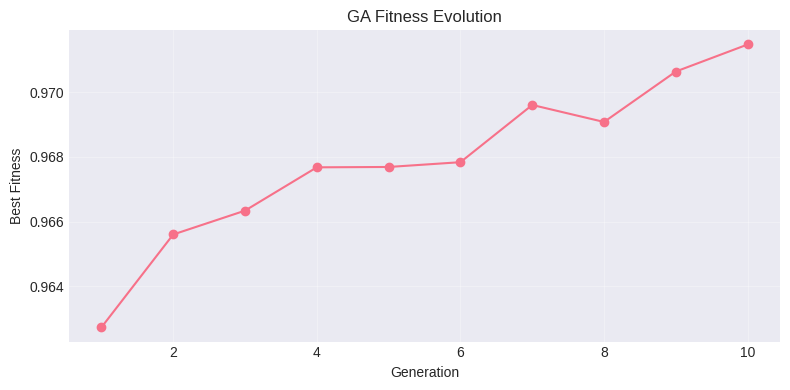

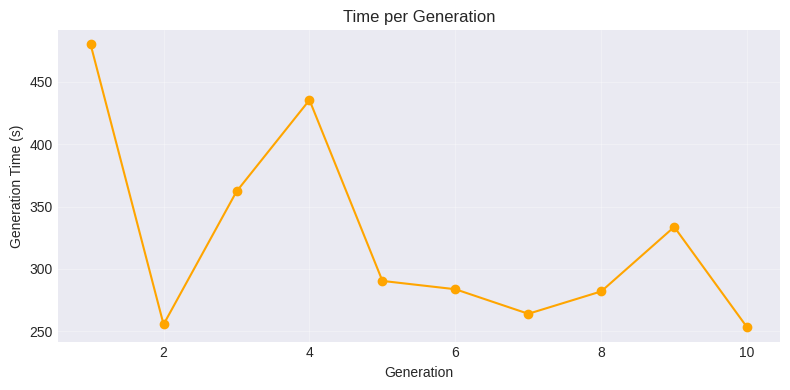


Selected Features:
------------------------------------------------------------
 1. Total Fwd Packets
 2. Bwd Packet Length Mean
 3. Flow Packets/s
 4. Flow IAT Mean
 5. Flow IAT Max
 6. Flow IAT Min
 7. Fwd IAT Max
 8. Fwd IAT Min
 9. Bwd IAT Mean
10. Bwd IAT Std
11. Bwd IAT Min
12. Fwd URG Flags
13. Bwd Packets/s
14. Min Packet Length
15. Max Packet Length
16. Packet Length Std
17. Packet Length Variance
18. PSH Flag Count
19. ACK Flag Count
20. CWE Flag Count
21. Avg Fwd Segment Size
22. Avg Bwd Segment Size
23. Bwd Avg Bytes/Bulk
24. Subflow Fwd Packets
25. Subflow Bwd Packets
26. Subflow Bwd Bytes
27. Init_Win_bytes_forward
28. Init_Win_bytes_backward
29. min_seg_size_forward
30. Active Std
31. Active Max
32. Active Min
33. Idle Mean


In [ ]:
# Plot fitness evolution
plt.figure(figsize=(8,4))
plt.plot(range(1, len(ga_selector.fitness_history)+1), ga_selector.fitness_history, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('GA Fitness Evolution')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# plot generation time
plt.figure(figsize=(8,4))
plt.plot(range(1, len(ga_selector.generation_times)+1), ga_selector.generation_times, marker='o', color='orange')
plt.xlabel('Generation')
plt.ylabel('Generation Time (s)')
plt.title('Time per Generation')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display selected features
print("\nSelected Features:")
print("-"*60)
for i, feat in enumerate(selected_features, 1):
    print(f"{i:2d}. {feat}")

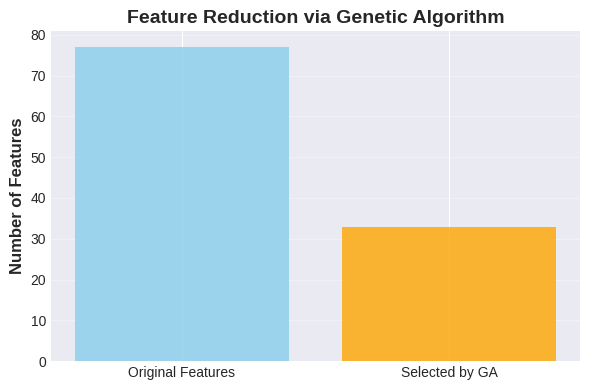

In [ ]:
# Feature reduction plot
plt.figure(figsize=(6,4))
plt.bar(
    ['Original Features', 'Selected by GA'],
    [len(feature_names), len(selected_features)],
    color=['skyblue', 'orange'],
    alpha=0.8
)
plt.ylabel("Number of Features", fontsize=12, fontweight='bold')
plt.title("Feature Reduction via Genetic Algorithm", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Percentage reduction info
reduction_pct = (1 - len(selected_features)/len(feature_names)) * 100
print(f"\nFeature reduction: {len(feature_names)} → {len(selected_features)} "
      f"({reduction_pct:.1f}% reduction)")


Feature reduction: 77 → 33 (57.1% reduction)


## Sacving GA Feature Selection Metadata

In [ ]:
save_path = '/content/drive/MyDrive/CI CW/ga_feature_selection.npz'

np.savez(
    save_path,
    selected_mask=selected_mask,
    selected_features=selected_features
)

print("✓ GA feature selection saved")

✓ GA feature selection saved
